In [1]:

import torch
from torch import nn
import torch.nn.init as init

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import random
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, Recall, Precision, F1Score, ConfusionMatrix
import requests
from pathlib import Path
import os
import numpy as np
from timeit import default_timer as timer
from tqdm.auto import tqdm
import math
from helper_functions import print_train_time
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from contextlib import nullcontext
import torch, torch.backends.cudnn as cudnn, torch.backends.cuda as cuda_bk


c:\Users\Altuk\OneDrive\repos\skill-builder-process\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = pick_device()

# CUDA-only speed toggles (guard them!)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True          # good for speed with static shapes
    torch.backends.cuda.matmul.allow_tf32 = True   # TF32 fast matmul on Ampere+
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")     # prefers fast float32 kernels
print(device)

cuda


c:\Users\Altuk\OneDrive\repos\skill-builder-process\.venv\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed=42)

In [4]:
def torch_generator(seed=42):
    g = torch.Generator()
    g.manual_seed(seed)
    return g
    

def worker_init_fn(worker_id):
    seed = 42 + worker_id
    np.random.seed(seed); random.seed(seed)

In [5]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

STL10_MEAN = (0.4467, 0.4398, 0.4066)
STL10_STD  = (0.2603, 0.2566, 0.2713)

#transforms for dtaset
def build_transforms(stage:str="train", size:int=32, pad:int=2, flip:float=0.5,
                     dataset:str="cifar10", aug_jitter:bool=False, erasing_p:float=0.0,
                     resize: bool = False) -> transforms.Compose:
    if dataset.lower() == "cifar10":
        mean, std = CIFAR10_MEAN, CIFAR10_STD
    elif dataset.lower() == 'stl10':
        mean, std = STL10_MEAN, STL10_STD
    else:
        ValueError(f"Unknown dataset: {dataset}")

    resize_if_needed = []
    if resize:
        resize_if_needed = [transforms.Resize(size, transforms.InterpolationMode.BILINEAR)]
        
    train_tfms = [
        transforms.RandomCrop(size, padding=pad),
        transforms.RandomHorizontalFlip(p=flip),
    ]
    
    if aug_jitter:
        train_tfms.append(transforms.ColorJitter(0.2, 0.2, 0.2, 0.1))
    
    train_tfms = train_tfms + resize_if_needed + [
        transforms.ToTensor(),
        transforms.Normalize(mean, std, inplace=True)
    ]
    
    if erasing_p > 0:
        train_tfms.append(transforms.RandomErasing(p=erasing_p))
    
    eval_tfms = resize_if_needed + [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
    
    if stage.lower() == "train":
        return transforms.Compose(train_tfms)
    elif stage in {"test", 'eval', 'val'}:
        return transforms.Compose(eval_tfms)
    else:
        raise ValueError("stage must be 'train', 'val', or 'test'")


In [6]:
#Build dataset
def build_datasets(train_tfms: transforms.Compose,
                   test_tfms: transforms.Compose,
                   root: str="./data",
                   dataset: str = "cifar10",
                   target_tfms = None, 
                   download: bool = True) -> tuple[torch.utils.data.Dataset, torch.utils.data.Dataset]:
    path = Path(root) if root is not None else Path("./data")
    path.mkdir(parents=True, exist_ok=True)
    
    
    if dataset.lower() == "cifar10":
        train_data = datasets.CIFAR10(
            root=path,
            train=True,
            download=download,
            transform=train_tfms,
            target_transform=target_tfms
        )
        test_data = datasets.CIFAR10(
            root=path,
            train=False,
            download=download,
            transform=test_tfms,
            target_transform=target_tfms
        )
    elif dataset.lower() == "stl10":
        train_data = datasets.STL10(
            root=path,
            split="train",
            download=download,
            transform=train_tfms,
            target_transform=target_tfms
        )
        test_data = datasets.STL10(
            root=path,
            split="test",
            download=download,
            transform=test_tfms,
            target_transform=target_tfms
        )
    else:
        raise ValueError(f"Unknown dataset: {dataset}")
    return train_data, test_data


In [7]:
#DataLoader
def build_loader(train_dataset: torch.utils.data.Dataset,
                 test_dataset: torch.utils.data.Dataset,
                 device: torch.device,
                 shuffle: bool = True,
                 batch: int = 128,
) -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    if device.type == "cuda":
        loader_kwargs = dict(
            batch_size=batch,
            num_workers=max(4, os.cpu_count() // 2),
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2
)
    elif device.type == "mps":
        loader_kwargs = dict(
            batch_size=batch,
            num_workers=0,          # multiprocessing not reliable on MPS
            pin_memory=False,
            persistent_workers=False,
)
    else:
        loader_kwargs = dict(batch_size=batch, num_workers=0)
    
    train_dataloader = DataLoader(train_dataset, shuffle=shuffle, **loader_kwargs)
    test_dataloader = DataLoader(test_dataset, shuffle=False, **loader_kwargs)
    
    return train_dataloader, test_dataloader

In [8]:
#train step
#Training func
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device | str = 'cpu',
               task: str = "multiclass",
               num_classes=None,
               scheduler: torch.optim.lr_scheduler._LRScheduler | None = None) -> tuple:
    """Performs one training epoch over data_loader."""

    # ---- setup ----
    if not isinstance(device, torch.device):
        device = torch.device(device)
    use_cuda = device.type == "cuda"
    use_mps  = device.type == "mps"

    model.train()
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)

    # AMP: unified, deprecation-safe
    # CUDA: use GradScaler + autocast("cuda", fp16)
    # MPS: use autocast("mps", fp16) if available; no scaler
    # CPU: no autocast (tiny nets), plain FP32
    if use_cuda:
        scaler = torch.amp.GradScaler("cuda")  # new API
        autocast_cm = torch.amp.autocast("cuda", dtype=torch.float16)
    else:
        scaler = None
        # Try MPS autocast (PyTorch ≥2.5); fallback if not supported
        if use_mps:
            try:
                autocast_cm = torch.amp.autocast("mps", dtype=torch.float16)
            except Exception:
                autocast_cm = nullcontext()
        else:
            autocast_cm = nullcontext()

    current_lr = optimizer.param_groups[0]["lr"]
    total_loss, total_n = 0.0, 0

    for X, y in tqdm(data_loader):
        non_block = use_cuda  # only helps on CUDA + pinned memory
        X = X.to(device, non_blocking=non_block)
        y = y.to(device, non_blocking=non_block)

        # Channels-last boosts CUDA convs; harmless elsewhere
        if use_cuda:
            X = X.contiguous(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        with autocast_cm:
            logits = model(X)
            batch_loss = loss_fn(logits, y)

        if scaler is not None:          # CUDA path
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:                            # MPS/CPU path
            batch_loss.backward()
            optimizer.step()

        # metrics/bookkeeping
        n = y.size(0)
        total_loss += batch_loss.detach().item() * n
        total_n    += n
        acc_metric.update(logits.detach(), y)

        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]

    avg_loss = total_loss / max(total_n, 1)
    avg_acc  = acc_metric.compute().item()
    print(f"Train loss: {avg_loss:.5f} | Train accuracy: {avg_acc*100:.2f}% | lr: {current_lr}")
    return avg_loss, avg_acc

In [9]:
#Testing func
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              device: torch.device | str = "cpu",
              task: str = "multiclass",
              num_classes=None) -> tuple:
    """Eval one epoch. Returns (avg_loss, avg_acc)."""
    if not isinstance(device, torch.device):
        device = torch.device(device)
    use_cuda = device.type == "cuda"
    use_mps  = device.type == "mps"

    model.eval()
    acc_metric = Accuracy(task=task, num_classes=num_classes).to(device)

    # AMP autocast (no GradScaler needed for eval)
    if use_cuda:
        autocast_cm = torch.amp.autocast("cuda", dtype=torch.float16)
    elif use_mps:
        # available on recent PyTorch; fallback silently if unsupported
        try:
            autocast_cm = torch.amp.autocast("mps", dtype=torch.float16)
        except Exception:
            autocast_cm = nullcontext()
    else:
        autocast_cm = nullcontext()

    total_loss, total_n = 0.0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            non_block = use_cuda  # only helps on CUDA + pinned memory
            X = X.to(device, non_blocking=non_block)
            y = y.to(device, non_blocking=non_block)

            if use_cuda:
                X = X.contiguous(memory_format=torch.channels_last)

            with autocast_cm:
                logits = model(X)
                batch_loss = loss_fn(logits, y)

            n = y.size(0)
            total_loss += batch_loss.detach().item() * n
            total_n    += n
            acc_metric.update(logits.detach(), y)

    avg_loss = total_loss / max(total_n, 1)
    avg_acc  = acc_metric.compute().item()
    print(f"Test loss: {avg_loss:.5f} | Test accuracy: {avg_acc*100:.2f}%")
    return avg_loss, avg_acc


In [10]:
def should_early_stop(history: list,
                      patience: int = 10,
                      key: str = "val_acc") -> bool:
    best = None
    epochs_no_improve = 0
    for row in history:
        value = row[key]
        if best is None or (("loss" in key and value < best) or ("loss" not in key and value > best)):
            best = value
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            return True
    return False

In [11]:
#Saving checkpoint 
def save_checkpoint(model: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    scheduler: torch.optim.lr_scheduler,
                    epoch: int,
                    best_metric: float,
                    seed: int = 42,
                    root: str | None = None):
    path = Path(root) if root is not None else Path(f"./{model.__class__.__name__}_checkpoints")
    path.mkdir(parents=True, exist_ok=True)
    
    file_path = path / f"checkpoint_epoch_{epoch:03d}.pth"
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        "epoch": epoch,
        "best_metric": best_metric,
        "seed": seed,
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved: {path}")

In [12]:
#loading checkpoint
def load_checkpoint(model: nn.Module,
                    optimizer: torch.optim.Optimizer | None = None,
                    scheduler: torch.optim.lr_scheduler._LRScheduler | None = None,
                    path: str | Path = None,
                    map_location: str = "auto"):
    """
    Load a training checkpoint (model, optimizer, scheduler, epoch, etc.).

    Returns:
        epoch (int): epoch number from which to resume
        best_metric (float): best metric so far
        seed (int): random seed stored in checkpoint
    """
    # Handle map_location automatically
    if map_location == "auto":
        map_location = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure path is Path object
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Checkpoint not found at: {path}")
    
    # Load checkpoint dictionary
    checkpoint = torch.load(path, map_location=map_location)

    # Restore model weights
    model.load_state_dict(checkpoint["model_state_dict"])

    # Restore optimizer and scheduler (if provided)
    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler is not None and checkpoint.get("scheduler_state_dict") is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    best_metric = checkpoint.get("best_metric", None)
    seed = checkpoint.get("seed", None)

    print(f"Checkpoint loaded from: {path} (epoch {epoch})")
    return epoch, best_metric, seed

In [13]:
def train_test_loop(history: list,
                    model: nn.Module,
                    train_data_loader: torch.utils.data.DataLoader,
                    test_data_loader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device | str = 'cpu',
                    num_classes: int = 10,
                    scheduler: torch.optim.lr_scheduler._LRScheduler | None = None,
                    epochs: int = 10,
                    timer_fn=timer,
                    log_path: str | None | Path = None,
                    save_checkpoint_root: Path | None = None,
                    save_checkpoint_best_val: float = float("-inf"),
                    seed: int = 42) -> list:

    # normalize device
    if not isinstance(device, torch.device):
        device = torch.device(device)

    path = Path(log_path) if log_path is not None else Path("csv/history_model.csv")
    path.parent.mkdir(parents=True, exist_ok=True)
    cols = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr", "elapsed_s"]

    t0 = timer_fn()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}\n-------")

        # train (your train_step already handles AMP/scheduler-per-batch)
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_data_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           num_classes=num_classes,
                                           scheduler=scheduler)

        # eval
        test_loss, test_acc = test_step(model=model,
                                        loss_fn=loss_fn,
                                        data_loader=test_data_loader,
                                        device=device,
                                        num_classes=num_classes)

        # LR logging (robust to schedulers that don't expose get_last_lr)
        try:
            lr = scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]["lr"]
        except Exception:
            lr = optimizer.param_groups[0]["lr"]

        # accurate wall time on CUDA (sync before reading timer)
        if device.type == "cuda":
            torch.cuda.synchronize()
        elapsed = timer_fn() - t0
        
        if test_acc > save_checkpoint_best_val:
            save_checkpoint_best_val = test_acc
            save_checkpoint(model, optimizer, scheduler,
                            epoch=epoch+1, best_metric=save_checkpoint_best_val, seed=seed, root=save_checkpoint_root)
        
        row = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc":  train_acc,
            "val_loss":   test_loss,
            "val_acc":    test_acc,
            "lr":         lr,
            "elapsed_s":  elapsed
        }
        history.append(row)
        if should_early_stop(history, patience=10, key="val_acc"):
            print(f"Early stopping at epoch {epoch+1}")
            break
    # fix the f-string (don’t wrap path in braces)
    print(f"Training finished in {timer_fn() - t0:.2f}s. Logs saved to history. Log after the training is finished")
    return history

In [14]:
def build_optimizer(model: torch.nn.Module,
                    optimizer_name: str = "adam",
                    lr: float = 0.001,
                    weight_decay: float = 5e-4,
                    momentum: float = 0.9) -> torch.optim.Optimizer:

    
    optimizer_name = optimizer_name.lower()

    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optimizer_name == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optimizer_name == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    return optimizer

In [15]:
def build_scheduler(optimizer: torch.optim.Optimizer,
                    steps_per_epoch: int,
                    max_lr: float = 3e-3,
                    epochs: int = 20,
                    pct_start=0.3,
                    anneal_strategy: str = 'cos',
                    div_factor: int = 10,
                    final_div_factor: int= 10):
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=max_lr,                 # peak LR
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=pct_start,               
        anneal_strategy=anneal_strategy,       
        div_factor=div_factor,               
        final_div_factor=final_div_factor          
    )
    return scheduler

In [16]:
def collecting_preds(model: nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     device: torch.device):
    y_trues, y_preds = [], []
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device); y = y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            y_trues.append(y.cpu())
            y_preds.append(preds.cpu())
    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds)

    return y_trues, y_preds

In [17]:
def eval_model(y_pred: torch.Tensor,
               y_true: torch.Tensor,
               model_name: str = 'model_0',
               task: str = 'multiclass',
               num_classes: int = 10,
               ) -> dict[dict]:
    """Evaluate model predictions using multiple metrics.
        Accuracy, Precision, Recall, F1 score."""
    
    acc = Accuracy(task=task, num_classes=num_classes)
    precision = Precision(task=task, num_classes=num_classes, average='macro')
    recall = Recall(task=task, num_classes=num_classes, average='macro')
    f1_score = F1Score(task=task, num_classes=num_classes, average='macro')
    
    metrics = {"acc": acc(y_pred, y_true).item(),
                "precision": precision(y_pred, y_true).item(),
                "recall": recall(y_pred, y_true).item(),
                "f1_score": f1_score(y_pred, y_true).item()}
    
    return {model_name: metrics}
    
    

In [18]:
tr_tfms, te_tfms = build_transforms(stage="train", aug_jitter=True, erasing_p=0.25), build_transforms(stage="test")
train_data, test_data = build_datasets(train_tfms=tr_tfms, test_tfms=te_tfms)

In [19]:
NUM_CLASSES = len(test_data.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9158674..1.7560488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4972931..1.7710396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8759745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9641825..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4488223..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0942786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.497293

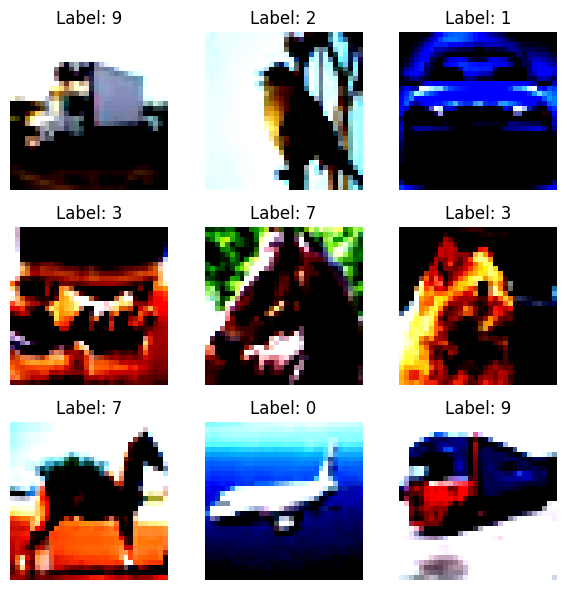

In [20]:
set_seed(seed=42)
indices = random.sample(range(len(test_data)), 9)

fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, idx in zip(axes.flat, indices):
    img, label = test_data[idx]
    if isinstance(img, torch.Tensor):
        img = img.permute(1,2,0)
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.7410581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8307058..1.4081607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7195683..1.3605304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.693943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9100897..1.2013928].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8307058..1.4081607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7195683

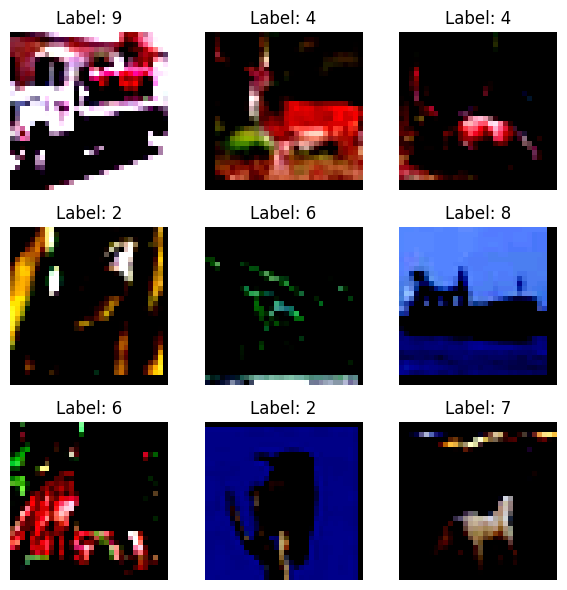

In [21]:
set_seed(seed=42)
indices = random.sample(range(len(train_data)), 9)

fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, idx in zip(axes.flat, indices):
    img, label = train_data[idx]
    if isinstance(img, torch.Tensor):
        img = img.permute(1,2,0)
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [22]:
set_seed(seed=42)
tr_dataloader, te_dataloader = build_loader(train_data, test_data, device=device, shuffle=True,)

In [23]:
#Model 0
class CifarModelV0(nn.Module):
    def __init__(self,
                 input_shade: int = 3,
                 hidden_units: int = 32,
                 output_shape: int = 10,
                 image_size: int = 32,
                 use_channels_last: bool = False,
                 init_kaiming: bool = True,
                 dropout_p:int = 0.10):
        super().__init__()
        h2 = hidden_units * 2
        h3 = hidden_units * 4
        self.image_size = image_size
        self.use_channels_last = use_channels_last
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shade, out_channels=hidden_units, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(hidden_units, h2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(h2),
            nn.ReLU(inplace=True),
            nn.Conv2d(h2, h2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(h2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(h2, h3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(h3),
            nn.ReLU(inplace=True),
            nn.Conv2d(h3, h3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(h3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # [B, C, H, W] -> [B, C, 1, 1]
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(h3, output_shape)
        
        if init_kaiming:
            self._init_weights()

        # Optional memory format for faster CUDA convs (harmless elsewhere)
        if self.use_channels_last and torch.cuda.is_available():
            self.to(memory_format=torch.channels_last)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        # Make input channels-last if requested (helps on CUDA + AMP)
        if self.use_channels_last and x.is_contiguous(memory_format=torch.contiguous_format):
            x = x.contiguous(memory_format=torch.channels_last)
            
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.gap(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
set_seed(seed=42)
model_0 = CifarModelV0(
    input_shade=3,
    hidden_units=32,   
    output_shape=NUM_CLASSES,
    use_channels_last=(device.type == "cuda"),
    dropout_p=0.10
).to(device)

In [25]:
sum(p.numel() for p in model_0.parameters())

288746

In [26]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = build_optimizer(model=model_0)
scheduler = build_scheduler(optimizer=optimizer, steps_per_epoch=len(tr_dataloader))

In [27]:
set_seed(seed=42)
# Initialize
history = []
EPOCHS = 10

# Run train/eval loop
train_test_loop(
    history=history,
    model=model_0,
    train_data_loader=tr_dataloader,
    test_data_loader=te_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    num_classes=NUM_CLASSES,
    epochs=EPOCHS,
    scheduler=scheduler
)

# Convert once after training (the function already appends per epoch)
hist_df = pd.DataFrame(history)

# Quick sanity check
print(hist_df.tail(3))

# Save once at the end (more efficient than re-writing each epoch)
out_path = Path("csv/history_model_0_cifar.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
hist_df.to_csv(out_path, index=False)
print(f"\nSaved final training history to {out_path.resolve()}")

Epoch: 1
-------


100%|██████████| 391/391 [00:53<00:00,  7.34it/s]


Train loss: 1.74162 | Train accuracy: 41.88% | lr: 0.0004810164500990109


100%|██████████| 79/79 [00:23<00:00,  3.30it/s]



Test loss: 1.54448 | Test accuracy: 53.01%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 2
-------


100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Train loss: 1.47419 | Train accuracy: 56.16% | lr: 0.000975522163053159


100%|██████████| 79/79 [00:00<00:00, 165.41it/s]



Test loss: 1.36389 | Test accuracy: 60.90%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 3
-------


100%|██████████| 391/391 [00:12<00:00, 31.03it/s]


Train loss: 1.35591 | Train accuracy: 62.11% | lr: 0.0016509042963251982


100%|██████████| 79/79 [00:00<00:00, 160.11it/s]


Test loss: 1.58168 | Test accuracy: 54.97%
Epoch: 4
-------


100%|██████████| 391/391 [00:12<00:00, 31.26it/s]


Train loss: 1.26351 | Train accuracy: 67.02% | lr: 0.0023260439221740896


100%|██████████| 79/79 [00:00<00:00, 178.41it/s]


Test loss: 1.21820 | Test accuracy: 68.78%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 5
-------


100%|██████████| 391/391 [00:12<00:00, 31.32it/s]


Train loss: 1.19231 | Train accuracy: 70.68% | lr: 0.002819887146685254


100%|██████████| 79/79 [00:00<00:00, 179.89it/s]


Test loss: 1.40242 | Test accuracy: 64.09%
Epoch: 6
-------


100%|██████████| 391/391 [00:12<00:00, 31.19it/s]


Train loss: 1.14883 | Train accuracy: 72.79% | lr: 0.002999999755439336


100%|██████████| 79/79 [00:00<00:00, 173.69it/s]



Test loss: 1.18519 | Test accuracy: 71.98%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 7
-------


100%|██████████| 391/391 [00:12<00:00, 31.31it/s]


Train loss: 1.11221 | Train accuracy: 74.73% | lr: 0.0029625780657302043


100%|██████████| 79/79 [00:00<00:00, 169.19it/s]



Test loss: 1.09328 | Test accuracy: 75.47%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 8
-------


100%|██████████| 391/391 [00:12<00:00, 31.41it/s]


Train loss: 1.08859 | Train accuracy: 75.75% | lr: 0.0028525687672457663


100%|██████████| 79/79 [00:00<00:00, 178.15it/s]


Test loss: 1.24941 | Test accuracy: 68.88%
Epoch: 9
-------


100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


Train loss: 1.07019 | Train accuracy: 76.89% | lr: 0.0026754881855708557


100%|██████████| 79/79 [00:00<00:00, 164.04it/s]


Test loss: 1.11382 | Test accuracy: 74.80%
Epoch: 10
-------


100%|██████████| 391/391 [00:12<00:00, 30.64it/s]


Train loss: 1.04882 | Train accuracy: 77.77% | lr: 0.0024402158804947686


100%|██████████| 79/79 [00:00<00:00, 157.28it/s]

Test loss: 1.09276 | Test accuracy: 76.22%
Checkpoint saved: CifarModelV0_checkpoints
Training finished in 195.05s. Logs saved to history. Log after the training is finished
   epoch  train_loss  train_acc  val_loss  val_acc        lr   elapsed_s
7      8    1.088586    0.75752  1.249414   0.6888  0.002853  168.631298
8      9    1.070188    0.76888  1.113815   0.7480  0.002675  181.768741
9     10    1.048824    0.77772  1.092756   0.7622  0.002440  195.042033

Saved final training history to C:\Users\Altuk\OneDrive\repos\skill-builder-process\ml_basics\notebooks\DL\csv\history_model_0_cifar.csv


In [28]:
def latest_checkpoint_dir(model):
    return Path(f"./{model.__class__.__name__}_checkpoints")

def get_latest_checkpoint_path(model) -> Path:
    ckpt_dir = latest_checkpoint_dir(model)
    files = sorted(ckpt_dir.glob("checkpoint_epoch_*.pth"))
    if not files:
        raise FileNotFoundError(f"No checkpoints in {ckpt_dir}")
    return files[-1]  # highest epoch

In [29]:
model_0_resume = CifarModelV0(
    input_shade=3,
    hidden_units=32,   
    output_shape=NUM_CLASSES,
    use_channels_last=(device.type == "cuda"),
    dropout_p=0.10
).to(device)

optimizer_resume = build_optimizer(model=model_0_resume)
scheduler_resume = build_scheduler(optimizer=optimizer_resume, steps_per_epoch=len(tr_dataloader))

In [ ]:
checkpoint_dir = latest_checkpoint_dir(model_0_resume)
if not checkpoint_dir.exists():
    raise FileNotFoundError(f"No checkpoint directory found at {checkpoint_dir.resolve()}. Run initial training first.")

ckpt_path = get_latest_checkpoint_path(model_0_resume)
epoch_loaded, best_metric, seed_loaded = load_checkpoint(
    model=model_0_resume,
    optimizer=optimizer_resume,
    scheduler=scheduler_resume,
    path=ckpt_path,
    map_location="auto"
)

# Ensure history is available; load from CSV if restarting a fresh session
if "history" not in globals() or history is None:
    hist_csv = Path("csv/history_model_0_cifar.csv")
    if hist_csv.exists():
        history = pd.read_csv(hist_csv).to_dict(orient="records")
    else:
        history = []

EXTRA_EPOCHS = 20  # run 20 more epochs
train_test_loop(
    history=history,
    model=model_0_resume,
    train_data_loader=tr_dataloader,
    test_data_loader=te_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer_resume,
    device=device,
    num_classes=NUM_CLASSES,
    epochs=EXTRA_EPOCHS,
    scheduler=scheduler_resume,
    save_checkpoint_root=checkpoint_dir,
    save_checkpoint_best_val=best_metric if best_metric is not None else float("-inf"),
    seed=seed_loaded if seed_loaded is not None else 42
)

Checkpoint loaded from: CifarModelV0_checkpoints\checkpoint_epoch_010.pth (epoch 10)
Epoch: 1
-------


100%|██████████| 391/391 [00:13<00:00, 29.56it/s]


Train loss: 1.03136 | Train accuracy: 78.45% | lr: 0.002158549387805609


100%|██████████| 79/79 [00:00<00:00, 170.44it/s]



Test loss: 0.96700 | Test accuracy: 81.74%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 2
-------


100%|██████████| 391/391 [00:12<00:00, 30.13it/s]


Train loss: 1.00473 | Train accuracy: 79.76% | lr: 0.0018446126415836567


100%|██████████| 79/79 [00:00<00:00, 180.77it/s]


Test loss: 1.05254 | Test accuracy: 77.08%
Epoch: 3
-------


100%|██████████| 391/391 [00:12<00:00, 30.50it/s]


Train loss: 0.98022 | Train accuracy: 81.22% | lr: 0.001514147741170172


100%|██████████| 79/79 [00:00<00:00, 166.18it/s]


Test loss: 0.95931 | Test accuracy: 81.92%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 4
-------


100%|██████████| 391/391 [00:13<00:00, 29.82it/s]


Train loss: 0.95940 | Train accuracy: 81.95% | lr: 0.001183725576573138


100%|██████████| 79/79 [00:00<00:00, 164.58it/s]


Test loss: 0.91350 | Test accuracy: 84.23%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 5
-------


100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


Train loss: 0.93046 | Train accuracy: 83.42% | lr: 0.0008699148948482519


100%|██████████| 79/79 [00:00<00:00, 138.65it/s]


Test loss: 0.87989 | Test accuracy: 85.29%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 6
-------


100%|██████████| 391/391 [00:13<00:00, 30.05it/s]


Train loss: 0.90444 | Train accuracy: 84.54% | lr: 0.0005884514739364903


100%|██████████| 79/79 [00:00<00:00, 161.04it/s]


Test loss: 0.85945 | Test accuracy: 86.66%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 7
-------


100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Train loss: 0.87817 | Train accuracy: 85.76% | lr: 0.0003534490650512609


100%|██████████| 79/79 [00:00<00:00, 178.25it/s]



Test loss: 0.84459 | Test accuracy: 87.24%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 8
-------


100%|██████████| 391/391 [00:12<00:00, 30.34it/s]


Train loss: 0.85114 | Train accuracy: 87.00% | lr: 0.0001766916702586708


100%|██████████| 79/79 [00:00<00:00, 171.97it/s]



Test loss: 0.83009 | Test accuracy: 87.85%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 9
-------


100%|██████████| 391/391 [00:12<00:00, 30.38it/s]


Train loss: 0.83446 | Train accuracy: 87.76% | lr: 6.704264340822397e-05


100%|██████████| 79/79 [00:00<00:00, 161.65it/s]


Test loss: 0.82102 | Test accuracy: 88.13%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 10
-------


100%|██████████| 391/391 [00:12<00:00, 30.29it/s]


Train loss: 0.82497 | Train accuracy: 88.27% | lr: 3.0000244560664276e-05


100%|██████████| 79/79 [00:00<00:00, 164.49it/s]


Test loss: 0.81580 | Test accuracy: 88.20%
Checkpoint saved: CifarModelV0_checkpoints
Epoch: 11
-------


  0%|          | 0/391 [00:00<?, ?it/s]



ValueError: Tried to step 7821 times. The specified number of total steps is 7820